In [1]:
# imports
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

subdir = 'results_M11_Sept20_2'
res = np.load('analysisSIM/' + subdir + 'res0.npy', allow_pickle=True)
sim_params = np.load('analysisSIM/' + subdir + '_sim_params0.npy', allow_pickle=True)


'''
subdir = 'results_M11_Sept20_speed2'
res = np.load('analysisSIM/' + subdir + 'res0.npy', allow_pickle=True)
sim_params = np.load('analysisSIM/' + subdir + '_sim_params0.npy', allow_pickle=True)
'''
res.shape, sim_params.shape

((66591, 4), (237, 6))

In [3]:
############### inject fake occultation signals ##################
from math import hypot, ceil
from math import pi, cos, tan
from scipy.special import jv  # Bessel function
from itertools import product

class memoize:

    """ Memoization decorator to cache repeatedly-used function calls """

    # stock code from http://avinashv.net

    def __init__(self, function):
        self.function = function
        self.memoized = {}

    def __call__(self, *args):
        try:
            return self.memoized[args]
        except KeyError:
            self.memoized[args] = self.function(*args)
            return self.memoized[args]


@memoize
def lommel(n, a, b):

    """ Calculates the nth lommel function """

    U = 0
    for k in range(0, 100000):
        sum = ((-1)**k * (a/b)**(n+2*k) * jv(n+2*k, pi*a*b))
        U += sum
        if abs(sum) < 0.00001:
            return U
    raise ValueError("Failure to converge")


@memoize
def generatePoints(starR):

    """ Models star as an array of uniformly distributed point sources """

    if starR == 0:  # model as point source
        return np.array([(0,0)])
    n = 5  # number of points to model 1D radius of star
    pairs = np.array([item for item in product(np.linspace(-starR, starR, 2*n-1), repeat=2) if hypot(item[0], item[1]) <= starR])
    return pairs


def diffractionCalc(r, p, starR, lam, D, b):

    """ Analytically calculates intensity at a given distance from star centre """

    # r is distance between line of sight and centre of the disk, in fresnel scale units
    # p is radius of KBO, in fresnel scale units
    pts = generatePoints(starR)
    r = fresnel(r, lam, D)
    res = 0
    effR = np.round(np.hypot((r - pts[:, 0]), (pts[:, 1]-b)), 2)
    coslist = np.cos(0.5*pi*(effR**2 + p**2))
    sinlist = np.sin(0.5*pi*(effR**2 + p**2))
    l = len(pts)
    for n in range(0, l):
        if effR[n] > p:
            U1 = lommel(1, p, effR[n])
            U2 = lommel(2, p, effR[n])
            res += (1 + (U2 ** 2) + (U1 ** 2) + 2*(U2*coslist[n] - U1*sinlist[n]))
        elif effR[n] == p:
            res += (0.25 * ((jv(0, pi*p*p)**2) + 2*cos(pi*p*p)*jv(0, pi*p*p) + 1))
        else:
            res += ((lommel(0, effR[n], p)**2) + (lommel(1, effR[n], p) ** 2))
    return res / l


def fresnel(x, lam, D):

    """ Converts value to fresnel scale units """
    return x / (lam*D/2.)**(1/2.)


def generateKernel(lam, objectR, b, D, starR):

    """ Calculates the light curve at a given wavelength """

    p = fresnel(objectR, lam, D)  # converting KBO radius to Fresnel Scale
    s = fresnel(starR, lam, D)  # converting effective star radius to Fresnel Scale
    b = fresnel(b, lam, D)
    #r = 25000.  # distance between line of sight and centre of the disk in m
    r = 50000
    z = [diffractionCalc(j, p, s, lam, D, b) for j in np.arange(-r, r, 10)]
    return z


def defineParam(startLam, endLam, objectR, b, D, angDi):

    """ Simulates light curve for given parameters """

    # startLam: start of wavelength range, m
    # endLam: end of wavelength range, m
    # objectR: radius of KBO, m
    # b: impact parameter, m
    # D: distance from KBO to observer, in AU
    # angDi: angular diameter of star, mas
    # Y: light profile during diffraction event

    D *= 1.496e+11 # converting to metres
    starR = effStarRad(angDi, D)
    n = 18
    weights = np.array([0.19570672, 0.25023261, 0.2839096 , 0.21618307, 1. ,
       0.99264115, 0.7642776 , 0.60915081, 0.47424386, 0.36451124,
       0.27732518, 0.20631212, 0.14537288, 0.09838498, 0.06365699,
       0.03863518, 0.02244682, 0.00967328])
    if endLam == startLam:
        Y = generateKernel(startLam, objectR, b, D, starR)
    else:
        step = (endLam-startLam) / n
        Y = np.array([generateKernel(lam, objectR, b, D, starR) for lam in np.arange(startLam, endLam, step)])
        #Y = np.sum(Y, axis=0)
        #Y /= n
        Y = np.average(Y, weights=weights, axis=0)
    return Y


def effStarRad(angDi, D):

    """ Determines projected star radius at KBO distance """

    angDi /= 206265000.  # convert to radians
    return D * tan(angDi / 2.)


def vT(a, phi, vE):

    """ Calculates transverse velocity of KBO """

    # a is distance to KBO, in AU
    # phi is opposition angle, in degrees
    # vE is Earth's orbital speed, in m/s
    # returns vT, transverse KBO velocity, in m/s

    #return vE * ( 1 - (1./a)**(1/2.))
    phi_ = phi * (np.pi / 180) # degrees -> radians
    return vE * (np.cos(phi_) - ((1./a) * (1 - (np.sin(phi_) ** 2))) ** (1/2))



def integrateCurve(exposure, curve, totTime, shiftAdj):

    """ Reduces resolution of simulated light curve to match what would be observed for a given exposure time """

    curve = np.array(curve)
    timePerFrame = totTime / len(curve)
    numFrames = roundOdd(exposure/timePerFrame)
    if shiftAdj < 0:
        shiftAdj += 1
    shift = ((len(curve) / 2)% numFrames) - (numFrames-1)/2
    while shift < 0:
        shift += numFrames
    shift += int(numFrames*shiftAdj)
    for index in np.arange((numFrames-1)/2 + shift, len(curve)-(numFrames-1)/2, numFrames):
        indices = range(int(index - (numFrames-1)/2), int(index+1+(numFrames-1)/2))
        av = np.average(curve[indices])
        curve[indices] = av
    last = indices[-1]+1  # bins leftover if light curve length isn't divisible by exposure time
    shift = int(shift)
    curve[last:] = np.average(curve[last:])
    curve[:shift] = np.average(curve[:shift])
    return curve, numFrames


def roundOdd(x):

    """ Rounds x to the nearest odd integer """

    x = ceil(x)
    if x % 2 == 0:
        return int(x-1)
    return int(x)


def genCurve(exposure, startLam, endLam, objectRad, impact, dist, angDi, shiftAdj, phi):

    """ Convert diffraction pattern to time series """

    velT = vT(dist, phi, 29800)
    curve = defineParam(startLam, endLam, objectRad, impact, dist, angDi)
    n = len(curve)*10./velT
    curve, num = integrateCurve(exposure, curve, n, shiftAdj)
    return curve[::num]


exposure = 0.012 # seconds
startLam = 2e-7 # 4e-7 start of wavelength range
endLam = 11e-7 # end of wavelength range
#objectRad = 500 # object radius, m
#impact = 0 # impact parameter, m
#dist = 100 # object distance, AU
angDi = 0.02 # angular diameter of star, mas
shiftAdj = 0
#curve = genCurve(exposure, startLam, endLam, objectRad, impact, dist, angDi, shiftAdj)

In [4]:
# load data and generate a matrix of observations
files = [f for d, s, f in os.walk(subdir)][0]

# order the files
phot_files = []
seq_files = []
sky_files = []
batch_ids = np.arange(0, 1000).astype(str)
for b in batch_ids:
    for f in files:
        if 'photometry' in f and 'batch' + b + '.npy' in f:
            phot_files.append(f)
        elif 'seq' in f and 'batch' + b + '.npy' in f:
            seq_files.append(f)
        elif 'sky' in f and 'batch' + b + '.npy' in f:
            sky_files.append(f)
            
n = 0 # use as reference for array dimensions
fs = np.load(os.path.join(subdir, phot_files[n])) # use for shape info
ss = np.load(os.path.join(subdir, sky_files[n]))
data = np.zeros((len(phot_files), fs.shape[0], fs.shape[1])) # data matrix
t = np.zeros((len(seq_files), fs.shape[0])) # observation sequence numbers (i.e. time)
bkgs = np.zeros((len(sky_files), ss.shape[0], ss.shape[1]))

# staple together the data in files
def batch_files(files, arr):
    for i,file in enumerate(files):
        arr[i] = np.load(os.path.join(subdir, file))
    return arr

data = batch_files(phot_files, data)
t = batch_files(seq_files, t)
bkgs = batch_files(sky_files, bkgs)

# reshape and change dtype
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2]).astype(np.float32)
bkgs = bkgs.reshape(bkgs.shape[0] * bkgs.shape[1], bkgs.shape[2]).astype(np.float32)
t = t.flatten().astype(np.float32)


X = np.copy(data)

In [5]:
source_ids = np.unique(res[:,0])
source_ids

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       72, 73, 75, 76, 77, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 104, 106, 107, 109, 110,
       111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 125, 126,
       127, 130, 131, 132, 133, 134, 136, 137, 138, 139, 142, 143, 144,
       145, 147, 149, 150, 152, 154, 155, 158, 159, 160, 161, 162, 163,
       165, 166, 167, 168, 169, 170, 172, 173, 176, 178, 179, 180, 181,
       182, 184, 187, 188, 189, 191, 192, 193, 195, 197, 198, 199, 201,
       202, 203, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 220, 222, 223, 225, 226, 227, 228, 230, 233, 235, 236,
       243], dtype=object)

In [6]:
output = []
for i in source_ids: 
            
    try:
        res_ = np.array(res)[np.array(res)[:,0] == i]
    except IndexError:
        continue

    if len(res_) == 0:
        continue

    # identify peak SNR in a given window
    locations = res_[:,3]
    snr_peaks = res_[:,2]
    template_ids = res_[:,1]

    # unravel on locations and snr peaks from each and every template
    locs = []
    snrs = []
    for loc, snr_peak in zip(locations, snr_peaks):
        for l, sp in zip(loc, snr_peak):
            locs.append(l) # all locations of all snr peaks from all templates
            snrs.append(sp) # all snr peaks from all templates
    locs = np.array(locs)
    unique_locs = np.unique(locs) # to cut down iteration time below...
    snrs = np.array(snrs)

    window = 1000 # search region is loc +- window
    snr_maxs = []
    loc_check = []
    t_ids = []

    # divide time series into window sized grid in which to search for peaks
    grid = np.arange(0, X.shape[0], window) + (window/2)
    grid = grid.astype(int)

    #for uloc in unique_loc:
    for uloc in grid:

        # Already searched for peaks in this region?
        #if (np.abs(np.array(loc_check) - uloc) < window).any() == True:
        #    continue

        #snr_max = np.max(snrs[np.where(np.abs(locs - uloc) < window)])
        try:
            snr_max = np.max(snrs[np.where(np.abs(locs - uloc) < (window/2))])
        except ValueError: # zero-sized array if no peaks found in window
            continue
        loc_max = locs[np.where(snrs == snr_max)]

        # Already seen this candidate occultation?
        if snr_max in snr_maxs:
            continue

        # Threshold?
        if snr_max < 5:
            continue

        #print(np.max(snr_peaks[57]))   
        #print(template_ids[57])

        # find the template associated with this particular snr peak
        for sp,snrp in enumerate(snr_peaks):
            if snr_max in snrp:
                template_id = template_ids[sp]

        if np.abs(loc_max[0] - 240173) < 50:
            print(i, template_id, loc_max[0], snr_max)
        # record dip info to prevent doubling up
        snr_maxs.append(snr_max)
        loc_check.append(loc_max[0])
        t_ids.append(template_id)

    output.append((i, t_ids, loc_check, snr_maxs))

21 190 240127 5.16965854460315
38 402 240142 5.478800114366386


In [7]:
output = np.array(output, dtype=object)
output.shape

(194, 4)

In [8]:
output

array([[0, list([126, 123, 56, 279, 53, 339, 50, 554, 279]),
        list([90249, 94307, 131683, 155937, 242486, 247810, 260865, 282830, 283273]),
        list([5.714129869771497, 5.72458521323192, 5.290052183803151, 5.664080430274576, 5.228551537416776, 6.028392991159522, 5.102605102723474, 5.80644613848624, 5.642657006955847])],
       [1,
        list([410, 131, 58, 395, 404, 214, 3, 54, 333, 189, 28, 129, 189, 3, 395, 121, 68, 54, 189, 395, 62]),
        list([811, 82456, 115034, 145852, 152523, 155997, 156032, 171694, 173764, 197500, 238999, 239200, 241878, 247969, 248001, 250658, 259179, 260964, 261005, 269630, 277420]),
        list([5.61242539066132, 6.294542217245145, 5.289106519578772, 5.317789552012316, 5.08776690586253, 6.172743585958699, 6.392282408187952, 5.294628999515847, 5.002162256778071, 5.050230892717807, 5.75392496590728, 9.790745720134472, 7.5214507641554516, 5.7986829855952635, 5.3688426089195485, 5.527892477865476, 5.1876004311695825, 5.554366170594628, 5.452179

In [9]:
# find isolated loc_max values i.e. common to just a single source
# unravel all loc_max
loc_maxs = []
for locs in output[:,2]:
    for l in locs:
        loc_maxs.append(l)
loc_maxs = np.array(loc_maxs)

print(loc_maxs.shape)

loc_maxs_ = []
for i,loc_i in enumerate(loc_maxs):
    
    # compute differences between this loc_max and all others
    diffs = []
    for j,loc_j in enumerate(loc_maxs):
        if i != j:
            diffs.append(np.abs(loc_i - loc_j))
            
    diffs = np.array(diffs)
    
    #if np.any(diffs < window):
    if np.any(diffs < 50):
        continue
    # if loc_i found to be isolated, store this value
    else:
        loc_maxs_.append(loc_i)

loc_maxs_ = np.array(loc_maxs_)
print(loc_maxs_.shape)

(2102,)
(260,)


In [10]:
# now reassociate this peaks with their source and sigma value
peaks = []
for l_ in loc_maxs_:
    for i, loc_list in enumerate(output[:,2]):
        if l_ in loc_list:
            peaks.append([output[:,0][i], output[:,1][i][loc_list.index(l_)],
                          l_, output[:,3][i][loc_list.index(l_)]])
peaks = np.array(peaks)
peaks

array([[0.00000000e+00, 1.26000000e+02, 9.02490000e+04, 5.71412987e+00],
       [0.00000000e+00, 2.79000000e+02, 2.83273000e+05, 5.64265701e+00],
       [1.00000000e+00, 3.95000000e+02, 1.45852000e+05, 5.31778955e+00],
       ...,
       [2.30000000e+02, 1.41000000e+02, 1.78125000e+05, 7.09622839e+00],
       [2.33000000e+02, 3.00000000e+00, 3.37700000e+04, 8.76983908e+00],
       [2.33000000e+02, 2.62000000e+02, 1.65676000e+05, 5.23100192e+00]])

In [11]:
ordered_sim_params = sim_params[sim_params[:,0].argsort()]
ordered_sim_params

array([[0.00000e+00, 2.53969e+05, 1.00000e+03, 1.00000e+04, 0.00000e+00,
        7.50000e+03],
       [1.00000e+00, 1.03200e+05, 1.00000e+04, 1.00000e+04, 7.50000e+01,
        0.00000e+00],
       [2.00000e+00, 1.72570e+05, 1.00000e+04, 2.50000e+03, 5.00000e+01,
        5.00000e+03],
       ...,
       [2.43000e+02, 2.57874e+05, 2.50000e+02, 3.00000e+01, 5.00000e+01,
        1.00000e+04],
       [2.45000e+02, 3.50800e+04, 7.50000e+03, 5.00000e+03, 0.00000e+00,
        1.00000e+03],
       [2.56000e+02, 1.74112e+05, 5.00000e+03, 1.00000e+04, 5.00000e+01,
        1.00000e+04]])

In [12]:
def gen_template_bank(dmin, dmax, tmin, tmax, del_d, del_t):

    nd = int((dmax - dmin) / del_d)
    nt = int((tmax - tmin) / del_t)

    ds = np.linspace(dmin, dmax, nd)
    ts = np.linspace(tmin, tmax, nt).astype(int)

    # add in some finer delta_ts at small timescales
    ts = np.append(ts, np.arange(2, 21, 1)).astype(int)

    bank = [] # list as templates have different lengths
    params = [] # t and d for each template
    for d in ds:
        for t in ts:
            template = np.ones(t + 10) # buffer of 10 - U-shaped dip
            template[5 : t + 5] =  1 - d
            bank.append(template)
            params.append([d, t])

    return bank, params

temp_bank, temp_params = gen_template_bank(0.1, 1, 5, 505, 0.1, 10)
#temp_bank, temp_params = gen_template_bank(0.1, 1, 5, 2005, 0.1, 20)

In [13]:
#np.unique(temp_bank).shape

In [14]:
# apply shifts to peak positions
#for peak in peaks:
#    tp_id = int(peak[1])
#    peak[2] += temp_params[tp_id][1] # shift template

In [15]:
## inject the ocultation events
# unpack parameters
mid_points = []
for sps in ordered_sim_params:
    
    lc_id, t0, radius, dist, phi, b = sps
    
    # generate the curve and compute where the occultation midpoint is
    curve = genCurve(exposure, startLam, endLam, radius, b, dist, angDi, shiftAdj, phi)
    t1 = t0 + len(curve)
    mid_point = int((t1 + t0) / 2)
    mid_points.append(mid_point)


    t1 = t0 + len(curve)
    lc_id, t0, t1 = int(lc_id), int(t0), int(t1)
    X[:, lc_id][t0:t1] += (np.median(X[:, lc_id]) * (curve - 1))

X.shape

C:\Users\James\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\James\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(290000, 282)

In [16]:
def matched_filter_snr(template, data):

    # fourier transform template
    tf = np.fft.fft(template)

    # fourier transform data
    df = np.fft.fft(data)

    # compute (unnormalised) matched filter in frequency domain
    mff = tf.conjugate() * df

    # inverse fourier transform to time domain
    mft = np.fft.ifft(mff)
    mft = np.abs(mft)

    # matched filter (empirical) SNR in time domain
    snrt = (mft - np.median(mft)) / mad_std(mft)

    return snrt

In [17]:
#pos = np.load(os.path.join(subdir, 'positions.npy'))
#pos[128]

comp_stars: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 17, 19, 20, 26, 56, 89, 92, 211]
SNR: 14.847579216944865
Found: [4.00000e+00 8.16588e+05 2.50000e+03 4.00000e+01 5.00000e+01 2.50000e+03] 14.847579216944865
4
comp_stars: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 17, 19, 20, 26, 56, 89, 92, 211]
SNR: 17.13897586050454
Found: [7.00000e+00 7.32516e+05 2.50000e+03 4.00000e+01 7.50000e+01 0.00000e+00] 17.13897586050454
7
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 19, 20, 26, 56, 89, 92, 211]
SNR: 11.45206495219801
Found: [1.20000e+01 8.70797e+05 7.50000e+03 2.50000e+03 0.00000e+00 5.00000e+03] 11.45206495219801
12
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 19, 20, 26, 56, 89, 92, 211]
SNR: 7.65716195855147
Found: [2.70000e+01 5.30461e+05 1.00000e+04 1.00000e+03 5.00000e+01 1.00000e+04] 7.65716195855147
27
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 19, 20, 26, 56, 89, 92, 211]
SNR: 7.807617512142902
Found: [6.4000e+01 7.0678e+04 7.5000e+03 5.00

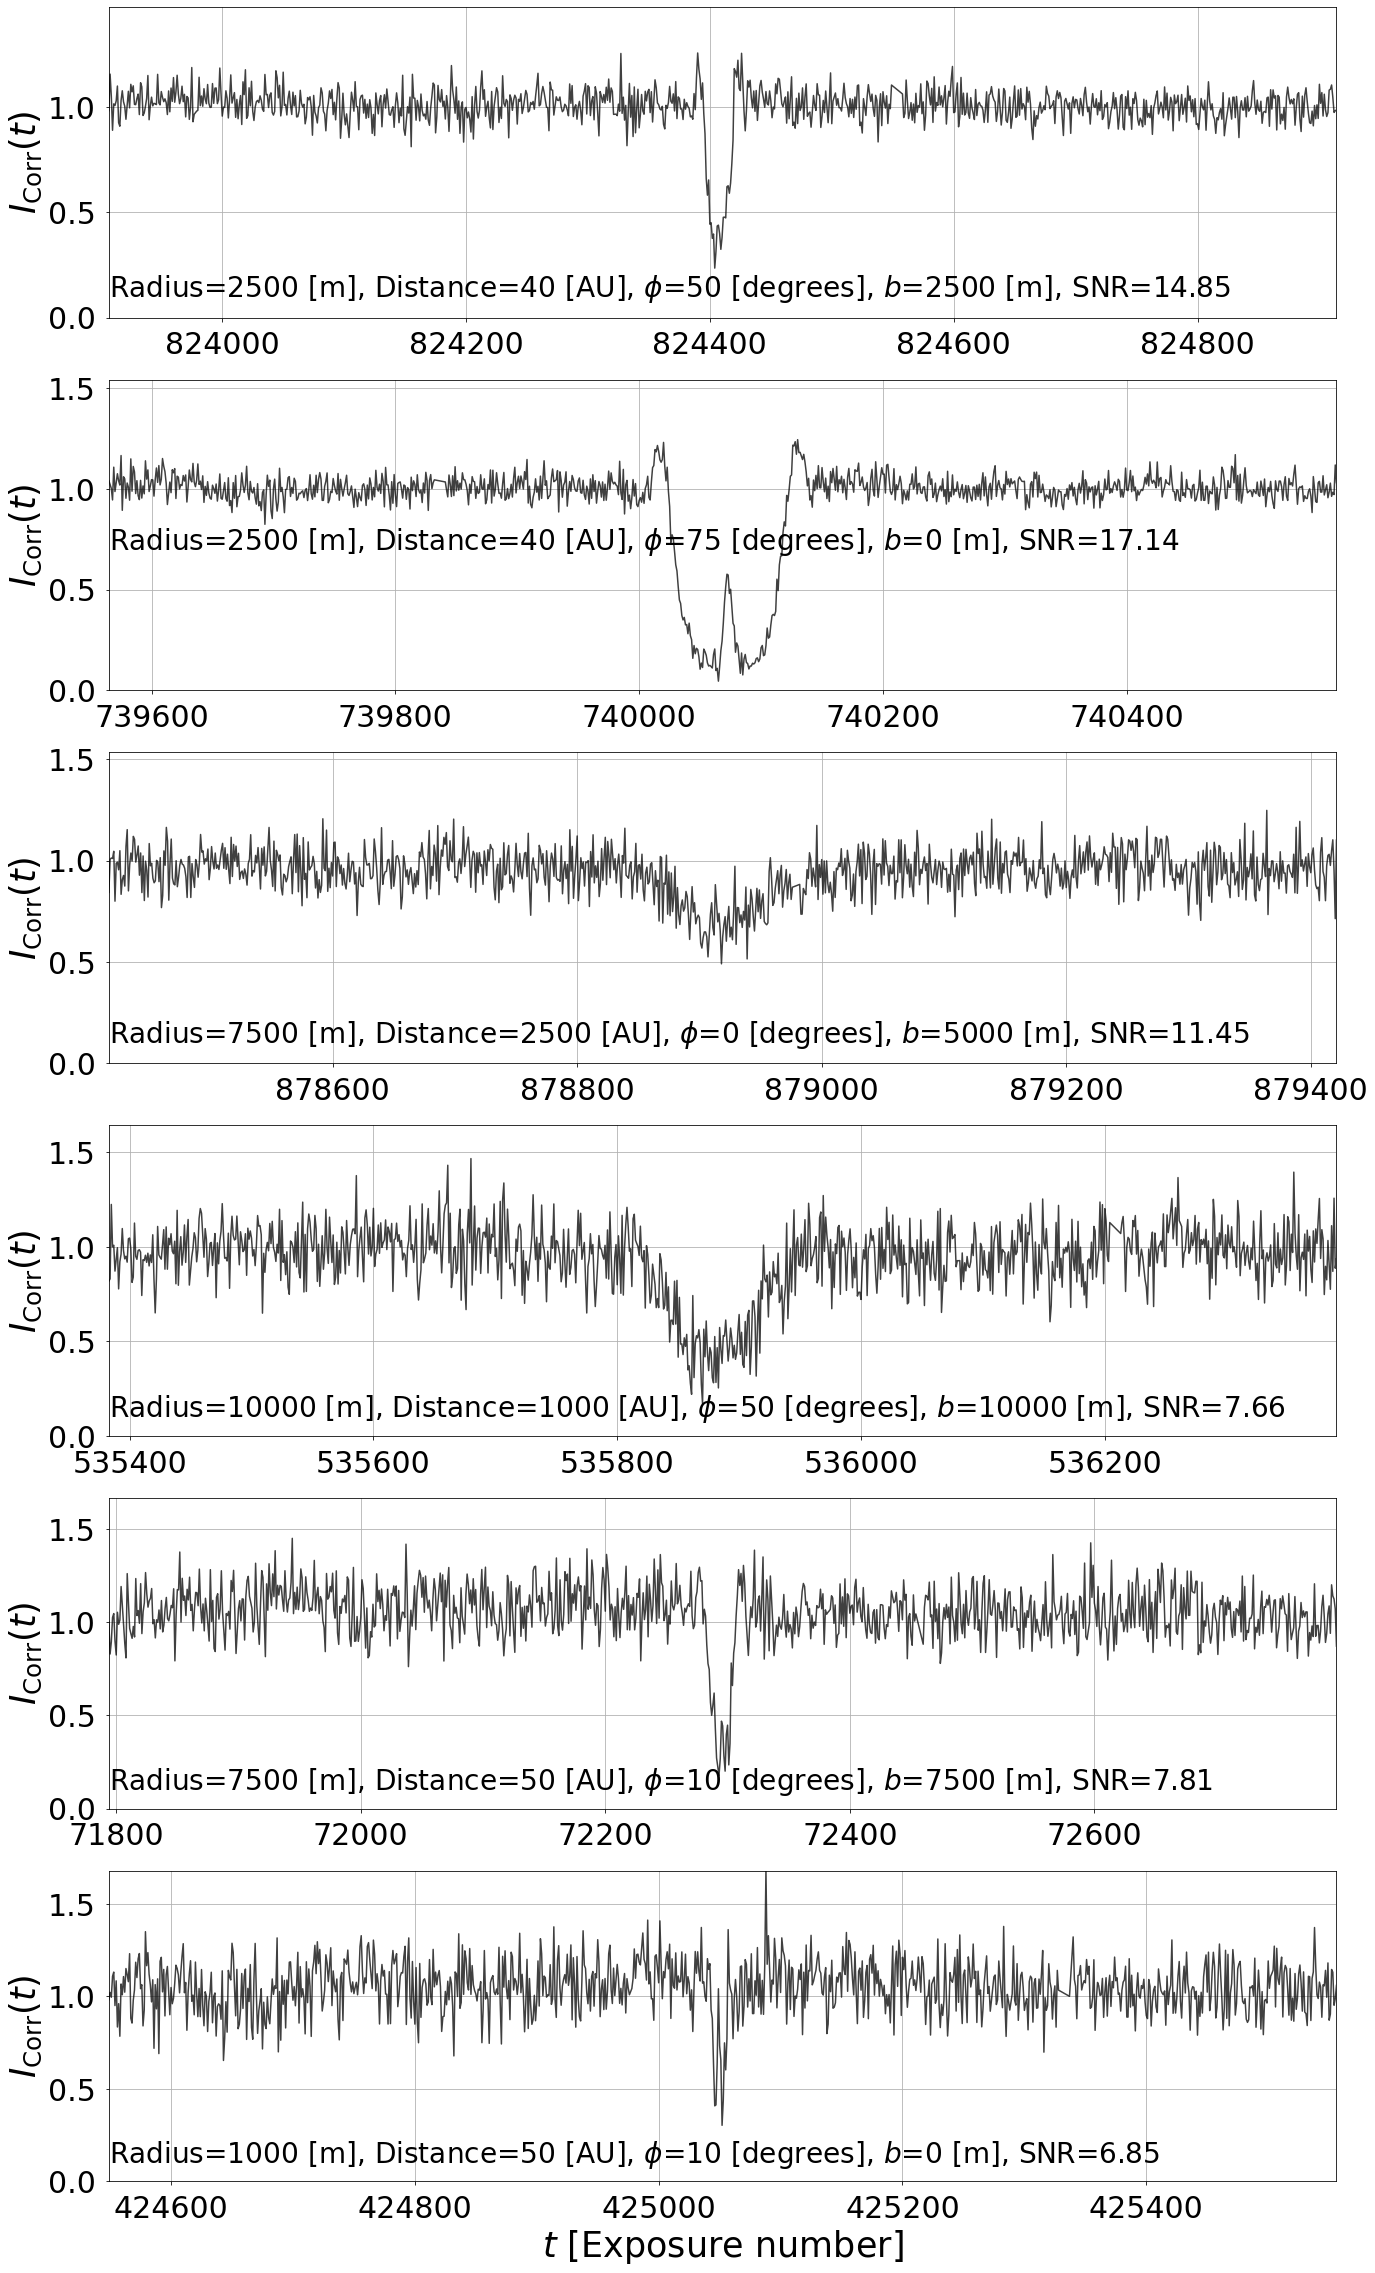

In [20]:
from tqdm import tqdm
#events_to_plot = [2, 8, 10, 21, 54, 73, 74, 77]
#events_to_plot = [1, 7, 10, 20, 26, 40]
#events_to_plot = np.arange(0, 100)
#events_to_plot = [1, 2, 5, 15, 18, 35]
events_to_plot = [4, 7, 12, 27, 64, 91]

pc = 0
recovered = []
missed = []

fig, ax = plt.subplots(figsize=(22,40), nrows=6, ncols=1)

for i, sps in enumerate(ordered_sim_params):
        

    lc_id, t0, radius, dist, phi, b = sps
    
    if lc_id not in events_to_plot:
        continue
    
    mid_point = mid_points[i]
    lc_id, mid_point = int(lc_id), int(mid_point)

    X_norm = X / np.median(X, axis=0)
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]  
    
    # if one or less comparison stars fail to meet the above condition, just use the stablest 10 OR brightest 10  
    if len(comparison_stars) <= 2:
        comparison_stars = np.arange(0, 10, 1) # brightest
        
    comp_stars = [c for c in comparison_stars if c != i]
    print('comp_stars:', comp_stars)
        
    wav = np.average(X_norm[:, comp_stars],
                 weights=np.std(X_norm[:, comp_stars], axis=0), axis=1)
    
    
    lc_ = X_norm[:, lc_id].T / wav
    
    
    #if 1. / mad_std(lc_) < 4:
        
    print('SNR:', 1. / mad_std(lc_))

    ######## plotting
    # window for plotting
    buffer = 250
    n1, n2 = int(mid_point - (2 * buffer)), int(mid_point + (2 * buffer))
    
    if np.min(lc_[n1:n2]) < 0.:
        continue

    # comparison stars
    if lc_id == 0:
        comp = 1
    else:
        comp = 0
    
    #21 50 240126 5.041786394330236
    #128 57 240173 21.00489266951848
    
    #comp_id = 21
    
    
    mstd = mad_std( X_norm[n1:n2, comp].T / wav[n1:n2])

    '''
    plt.figure(figsize=(20, 15))
    plt.plot(t[n1:n2],  lc_[n1:n2])
    plt.scatter(t[n1:n2], lc_[n1:n2])
    plt.plot(t[n1:n2], X_norm[n1:n2, comp].T / wav[n1:n2])
    plt.ylim(0, 1.5)
    plt.vlines(t[mid_point], -1, 10, color='black')
    plt.ylim(np.min(lc_[n1:n2]) - 10*mstd, np.median(lc_[n1:n2]) + 10*mstd)
    plt.grid()
    #plt.title('Source:%d, , $\sigma_{SNR}=%.3f$' % (lc_id, str(temp_params[peak]),
    #
    lc_id, t0, radius, dist, phi, b = sps
    plt.text(t[n1:n2][0] + 50, np.min(lc_[n1:n2]) - 5*mstd,
             'Radius=%d [m], Distance=%d [AU], $\phi$=%d [degrees], $b$=%d [m]' 
            % (radius, dist, phi, b), fontsize=20)
    plt.xlabel('$t$ [Exposure number]')
    plt.ylabel('$I(t)$')
    plt.show();
    '''
    
    '''
    template = temp_bank[57]
    one_pad = np.ones(len(lc_) - len(template))
    template_padded = np.append(template, one_pad)
    snrt = matched_filter_snr(template_padded, lc_)
    
    lc_comp = X_norm[:, comp_id].T / wav
    template_comp = temp_bank[50]
    one_pad = np.ones(len(lc_comp) - len(template_comp))
    template_padded = np.append(template_comp, one_pad)
    snrt_comp = matched_filter_snr(template_padded, lc_comp)
    
    plt.figure(figsize=(20, 15))
    #plt.plot(t[n1:n2] + temp_params[tp_id][1],  snrt[n1:n2])
    plt.plot(t[n1:n2],  snrt[n1:n2])
    plt.plot(t[n1:n2],  snrt_comp[n1:n2])
    plt.vlines(t[mid_point], -1, 10)
    plt.grid()
    plt.xlabel('$t$ [Exposure number]')
    plt.ylabel('$SNR(t)$')
    plt.show();
    '''

    
    # identify peaks assocaited with this light curve
    peaks_ = peaks[peaks[:,0] == int(lc_id)]

    
    # is there a peak near where the occultation should be?
    diffs = np.abs(t[peaks_[:,2].astype(int)] - t[mid_point])

    if np.any(diffs < 500):

        print('Found:', sps, 1. / mad_std(lc_))
        print(lc_id)
        recovered.append([lc_id, t0, radius, dist, phi, b, 1. / mad_std(lc_)])    
        
        
        fs = 30
        ax[pc].plot(t[n1:n2],  lc_[n1:n2], c='k', alpha=0.75)
        #ax[pc].scatter(t[n1:n2], lc_[n1:n2])
        #ax[pc].plot(t[n1:n2], X_norm[n1:n2, comp].T / wav[n1:n2])
        #ax[pc].vlines(t[mid_point], -1, 10, color='black')
        #ax[pc].set_ylim(np.min(lc_[n1:n2]) - 10*mstd, np.median(lc_[n1:n2]) + 10*mstd)
        ax[pc].set_ylim(0, np.median(lc_[n1:n2]) + 12.5*mstd)
        ax[pc].set_xlim(t[n1:n2][0], t[n1:n2][-1])
        ax[pc].grid()
        if pc == 1:
            ax[pc].text(t[n1:n2][0], 0.7,
                     'Radius=%d [m], Distance=%d [AU], $\phi$=%d [degrees], $b$=%d [m], SNR=%.2f' 
                    % (radius, dist, phi, b, 1. / mad_std(lc_)), fontsize=fs-2)    
        else:
            ax[pc].text(t[n1:n2][0], 0.1,
                     'Radius=%d [m], Distance=%d [AU], $\phi$=%d [degrees], $b$=%d [m], SNR=%.2f' 
                    % (radius, dist, phi, b, 1. / mad_std(lc_)), fontsize=fs-2)
        ax[pc].set_ylabel('$I_{\mathrm{Corr}}(t)$', fontsize=fs+5)
        ax[pc].tick_params(labelsize=fs, pad=10)
        if pc == 5:
            ax[pc].set_xlabel('$t$ [Exposure number]', fontsize=fs+5)

        pc += 1
        

    else:
        print('Missed:', sps, 1. / mad_std(lc_))
        missed.append([lc_id, t0, radius, dist, phi, b, 1. / mad_std(lc_)]) 
        continue
        
    if pc == 6:
        break
    
plt.savefig('Recovered_plots_Speed.png', bbox_inches='tight')
#plt.show()

19
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 71, 72, 74, 79]
SNR: 31.596926963421097
Found: [1.9000e+01 5.5974e+04 2.5000e+03 5.0000e+02 0.0000e+00 1.0000e+03] 31.596926963421097
26
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 71, 72, 74, 79]
SNR: 33.71326664449825
Found: [2.6000e+01 2.2391e+05 5.0000e+02 3.0000e+01 5.0000e+01 0.0000e+00] 33.71326664449825
30
comp_stars: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 

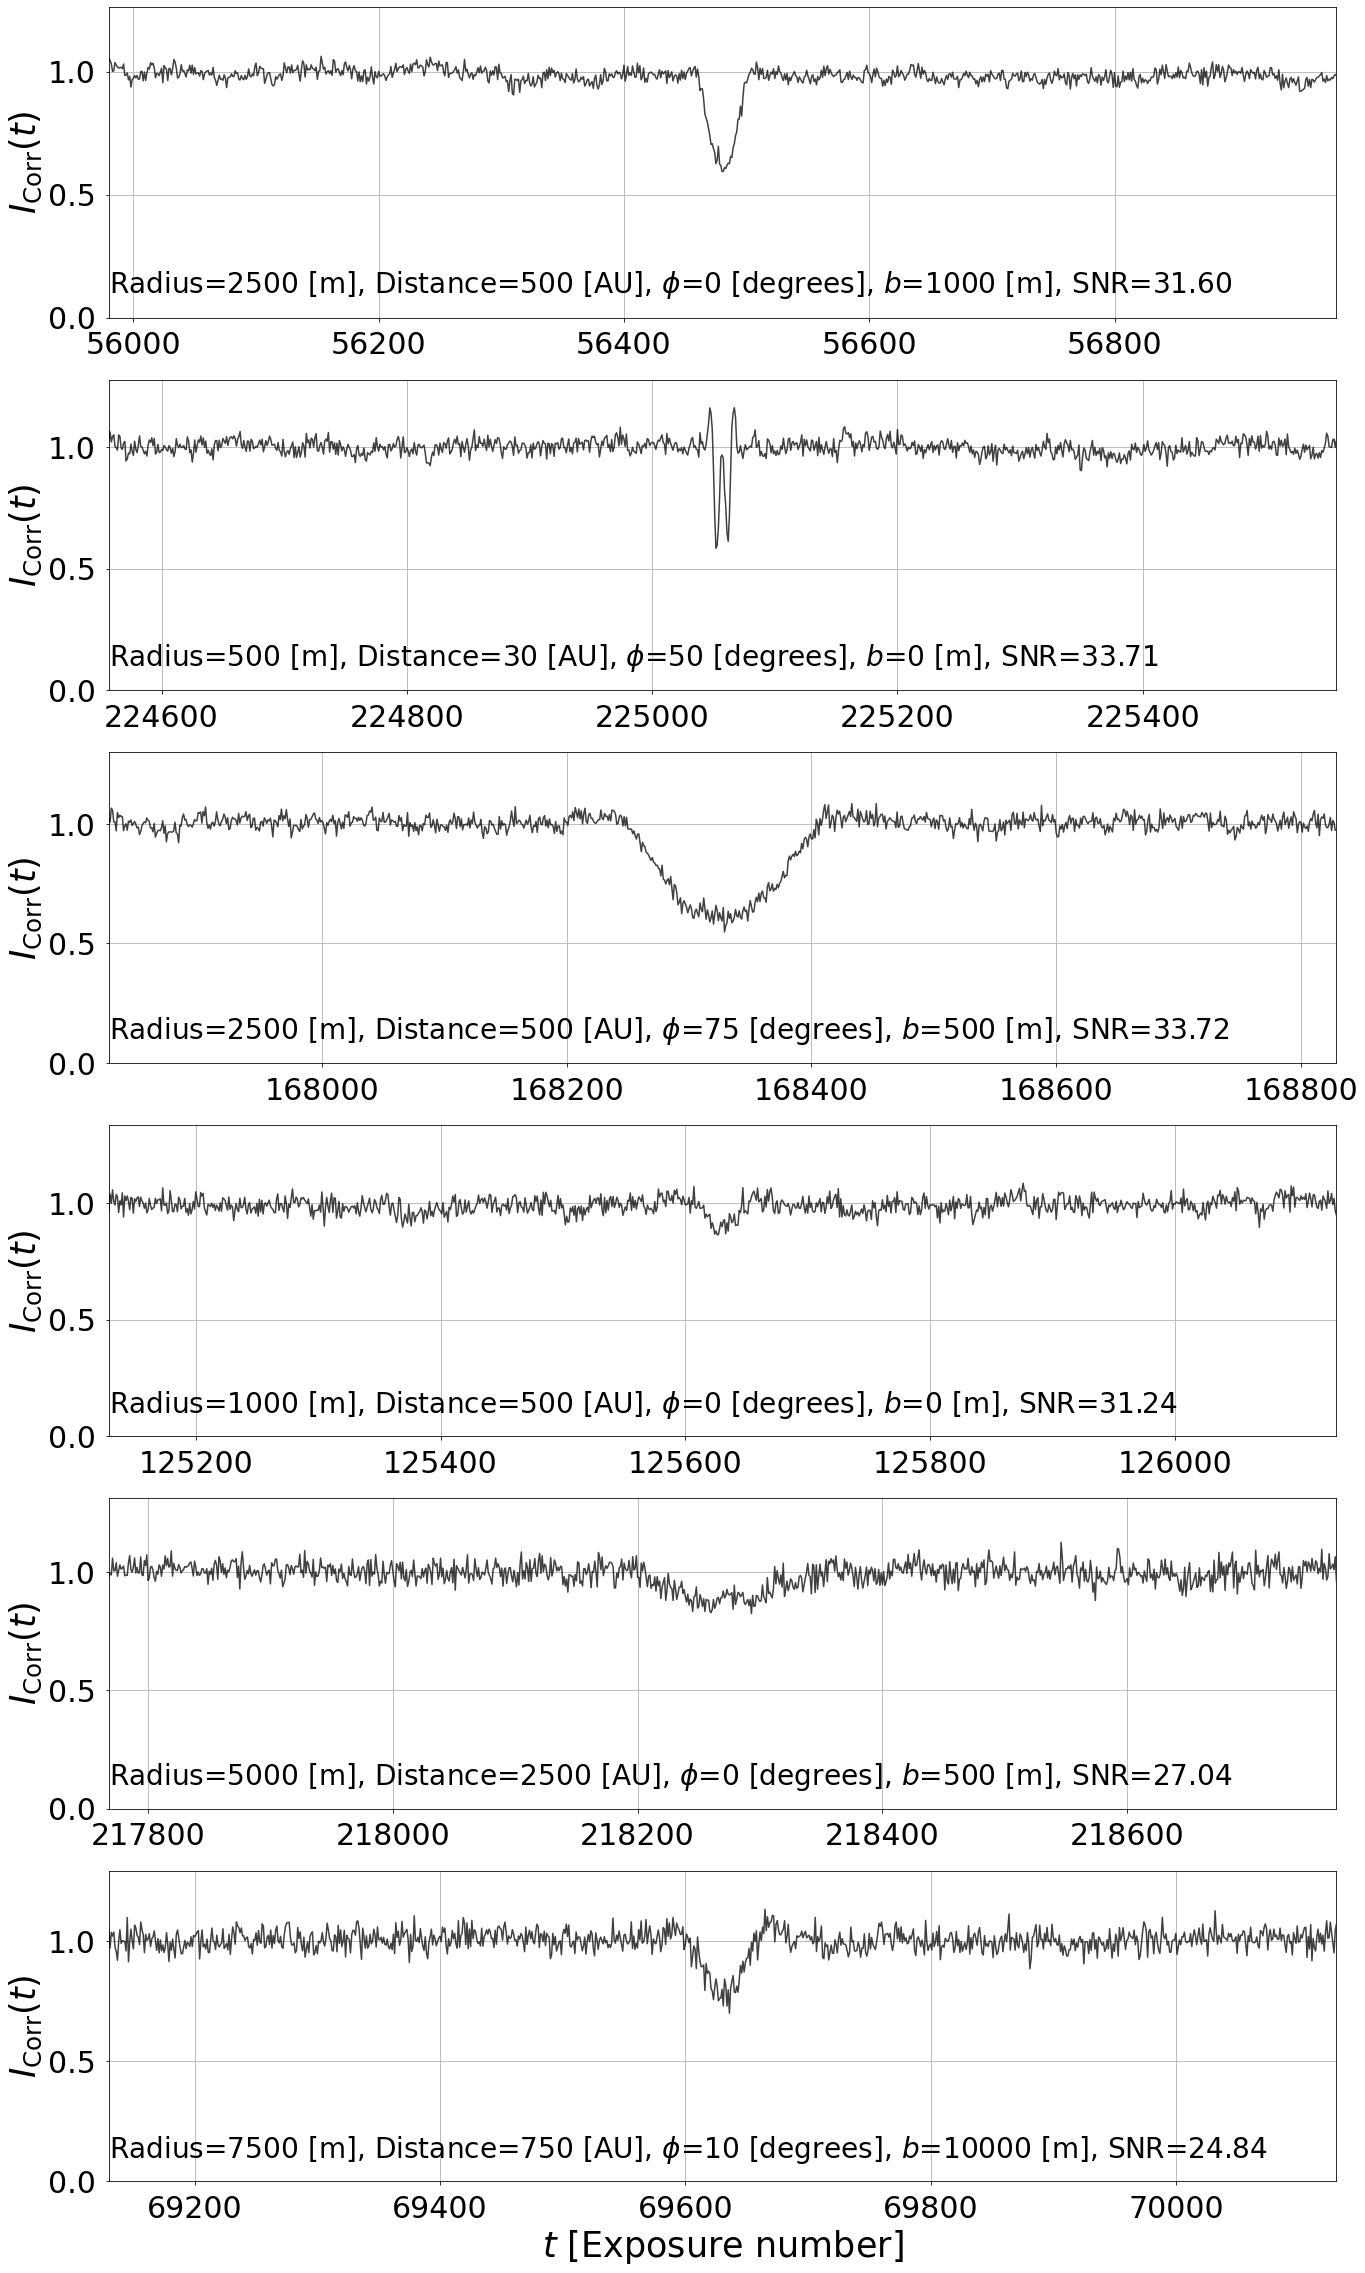

In [18]:
from tqdm import tqdm
#events_to_plot = [2, 8, 10, 21, 54, 73, 74, 77]
#events_to_plot = [2, 8, 21, 54, 74, 77]
#events_to_plot = [2, 7, 11, 62, 64, 79]

events_to_plot = [12, 21, 31, 35, 47, 58, 62, 65, 74, 77, 84, 85]
events_to_plot = [12, 31, 35, 65, 74, 77]
events_to_plot = [19, 26, 30, 34, 41, 45]

pc = 0
recovered = []
missed = []

fig, ax = plt.subplots(figsize=(22,40), nrows=6, ncols=1)

for i, sps in enumerate(ordered_sim_params):
    
    if i not in events_to_plot:
        continue
        
    print(i)
            
    lc_id, t0, radius, dist, phi, b = sps
    
    '''
    if radius != 10000:
        continue
    '''
    mid_point = mid_points[i]
    lc_id, mid_point = int(lc_id), int(mid_point)
    
    '''
    if lc_id != 128:
        continue
    '''
    X_norm = X / np.median(X, axis=0)
    comparison_stars = np.where(np.std(X_norm[:, :], axis=0) < 0.1)[0]  
    
    # if one or less comparison stars fail to meet the above condition, just use the stablest 10 OR brightest 10  
    if len(comparison_stars) <= 1:
        comparison_stars = np.arange(0, 10, 1) # brightest
        
    comp_stars = [c for c in comparison_stars if c != i]
    print('comp_stars:', comp_stars)
        
    wav = np.average(X_norm[:, comp_stars],
                 weights=np.std(X_norm[:, comp_stars], axis=0), axis=1)
    
    
    lc_ = X_norm[:, lc_id].T / wav
    
    #if 1. / mad_std(lc_) < 4:
        
    print('SNR:', 1. / mad_std(lc_))

    ######## plotting
    # window for plotting
    buffer = 250
    n1, n2 = int(mid_point - (2 * buffer)), int(mid_point + (2 * buffer))

    # comparison stars
    if lc_id == 0:
        comp = 1
    else:
        comp = 0
    
    #21 50 240126 5.041786394330236
    #128 57 240173 21.00489266951848
    
    #comp_id = 21
    
    
    mstd = mad_std( X_norm[n1:n2, comp].T / wav[n1:n2])
    
    '''
    print('Source:', i)
    plt.figure(figsize=(20, 15))
    plt.plot(t[n1:n2],  lc_[n1:n2])
    plt.scatter(t[n1:n2], lc_[n1:n2])
    plt.plot(t[n1:n2], X_norm[n1:n2, comp].T / wav[n1:n2])
    plt.ylim(0, 1.5)
    plt.vlines(t[mid_point], -1, 10, color='black')
    plt.ylim(np.min(lc_[n1:n2]) - 10*mstd, np.median(lc_[n1:n2]) + 10*mstd)
    plt.grid()
    #plt.title('Source:%d, , $\sigma_{SNR}=%.3f$' % (lc_id, str(temp_params[peak]),
    #
    lc_id, t0, radius, dist, phi, b = sps
    plt.text(t[n1:n2][0] + 50, np.min(lc_[n1:n2]) - 5*mstd,
             'Radius=%d [m], Distance=%d [AU], $\phi$=%d [degrees], $b$=%d [m]' 
            % (radius, dist, phi, b), fontsize=20)
    plt.xlabel('$t$ [Exposure number]')
    plt.ylabel('$I(t)$')
    plt.show();
    '''
    
    
    fs = 30
    ax[pc].plot(t[n1:n2],  lc_[n1:n2], c='k', alpha=0.75)
    #ax[pc].scatter(t[n1:n2], lc_[n1:n2])
    #ax[pc].plot(t[n1:n2], X_norm[n1:n2, comp].T / wav[n1:n2])
    #ax[pc].vlines(t[mid_point], -1, 10, color='black')
    #ax[pc].set_ylim(np.min(lc_[n1:n2]) - 10*mstd, np.median(lc_[n1:n2]) + 10*mstd)
    ax[pc].set_ylim(0, np.median(lc_[n1:n2]) + 12.5*mstd)
    ax[pc].set_xlim(t[n1:n2][0], t[n1:n2][-1])
    ax[pc].grid()
    ax[pc].text(t[n1:n2][0], 0.1,
             'Radius=%d [m], Distance=%d [AU], $\phi$=%d [degrees], $b$=%d [m], SNR=%.2f' 
            % (radius, dist, phi, b, 1. / mad_std(lc_)), fontsize=fs-2)
    ax[pc].set_ylabel('$I_{\mathrm{Corr}}(t)$', fontsize=fs+5)
    ax[pc].tick_params(labelsize=fs, pad=10)
    if pc == 5:
        ax[pc].set_xlabel('$t$ [Exposure number]', fontsize=fs+5)
        
    pc += 1
    
    
    '''
    template = temp_bank[57]
    one_pad = np.ones(len(lc_) - len(template))
    template_padded = np.append(template, one_pad)
    snrt = matched_filter_snr(template_padded, lc_)
    
    lc_comp = X_norm[:, comp_id].T / wav
    template_comp = temp_bank[50]
    one_pad = np.ones(len(lc_comp) - len(template_comp))
    template_padded = np.append(template_comp, one_pad)
    snrt_comp = matched_filter_snr(template_padded, lc_comp)
    
    plt.figure(figsize=(20, 15))
    #plt.plot(t[n1:n2] + temp_params[tp_id][1],  snrt[n1:n2])
    plt.plot(t[n1:n2],  snrt[n1:n2])
    plt.plot(t[n1:n2],  snrt_comp[n1:n2])
    plt.vlines(t[mid_point], -1, 10)
    plt.grid()
    plt.xlabel('$t$ [Exposure number]')
    plt.ylabel('$SNR(t)$')
    plt.show();
    '''

    # identify peaks assocaited with this light curve
    peaks_ = peaks[peaks[:,0] == int(lc_id)]


    # is there a peak near where the occultation should be?
    diffs = np.abs(t[peaks_[:,2].astype(int)] - t[mid_point])

    if np.any(diffs < 500):

        print('Found:', sps, 1. / mad_std(lc_))
        recovered.append([lc_id, t0, radius, dist, phi, b, 1. / mad_std(lc_)])      

    else:
        print('Missed:', sps, 1. / mad_std(lc_))
        missed.append([lc_id, t0, radius, dist, phi, b, 1. / mad_std(lc_)]) 
        continue

plt.savefig('Recovered_plots_Sensitivity.png', bbox_inches='tight')

In [48]:
recovered = np.array(recovered)
missed = np.array(missed)
recovered.shape, missed.shape

((50, 7), (136, 7))

In [1]:
# imports
import os
import numpy as np
from astropy.stats import mad_std
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# compute dataset durations
from datetime import datetime
path_to_data = "E:\McDonald backups"
subdirs = [s for d, s, f in os.walk(path_to_data)][0]
subdirs = [s for s in subdirs if 'results' in s ] # filter out any other directories
subdirs = [os.path.join(path_to_data, s) for s in subdirs]
subdir_durations = []
for s in subdirs:
    #log = read(os.path.join(s, 'housekeeping.log'))
    try:
        with open(os.path.join(s, 'housekeeping.log')) as log:
            lines = log.readlines()
            #print(lines[lines.index('Camera now collecting data')])
            for line in lines:
                if 'Camera now collecting data' in line:
                    t0 = line[11:19]
                    t1 = lines[-1][11:19]
                    hr0, min0, s0 = int(t0[:2]), int(t0[3:5]), int(t0[6:])
                    hr1, min1, s1 = int(t1[:2]), int(t1[3:5]), int(t1[6:])
                    day0, day1 = int(line[8:10]), int(lines[-1][8:10])
                    year, month = int(line[:4]), int(line[5:7])
                    datetime0 = datetime(year, month, day0, hr0, min0, s0)
                    datetime1 = datetime(year, month, day1, hr1, min1, s1)

                    duration = (datetime1 - datetime0).total_seconds() # seconds
                    subdir_durations.append([s, int(duration)])
    except FileNotFoundError:
        continue
subdir_durations = np.array(subdir_durations)

In [3]:
path = 'analysisSIM/results'
files = [f for d, s, f in os.walk(path)][0]
'''
path1 = 'analysisSIM/results'
files1 = [f for d, s, f in os.walk(path1)][0]
path2 = 'analysisSIM/results_check'
files2 = [f for d, s, f in os.walk(path2)][0]
'''
recovered_list = []
missed_list = []
recovered_list_speed = []
missed_list_speed = []


#rejects = ['results_M11', 'results_M11_Sept19_AGtest', 'results_M37', 'results_rtp_M11']
rejects = []

In [4]:
'''
for file in files:
    #if 'recovered' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    if 'recovered' in file and 'noFPreject' not in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    #if 'recovered' in file and 'speed' in file and '_alt' in file:
        recovered_list.append(file)
    #elif 'recovered' in file and 'speed' in file and '_alt' not in file:
    elif 'recovered' in file and 'noFPreject' not in file and 'speed' in file and file.split('_recovered')[0] not in rejects:
        recovered_list_speed.append(file)
    elif 'missed' in file and 'noFPreject' not in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
    #elif 'missed' in file and 'speed' in file and '_alt' in file:
        missed_list.append(file)
    #elif 'missed' in file and 'speed' in file and '_alt' not in file:
    elif 'missed' in file and 'noFPreject' not in file and 'speed' in file and file.split('_missed')[0] not in rejects:
        missed_list_speed.append(file)
'''
'''
for file in files:
    if 'recovered' in file and 'noFPreject' not in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
        recovered_list.append(file)
    elif 'missed' in file and 'noFPreject' not in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
        missed_list.append(file)
        
for file in files:
    if 'recovered' in file and 'noFPreject' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
        recovered_list_speed.append(file)
    elif 'missed' in file and 'noFPreject' in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
        missed_list_speed.append(file)
'''
'''
for file in files:
    #if 'recovered' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    if 'recovered' in file and 'diffFPcond' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    #if 'recovered' in file and 'speed' in file and '_alt' in file:
        recovered_list.append(file)
    #elif 'recovered' in file and 'speed' in file and '_alt' not in file:
    elif 'recovered' in file and 'diffFPcond' in file and 'speed' in file and file.split('_recovered')[0] not in rejects:
        recovered_list_speed.append(file)
    elif 'missed' in file and 'diffFPcond' in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
    #elif 'missed' in file and 'speed' in file and '_alt' in file:
        missed_list.append(file)
    #elif 'missed' in file and 'speed' in file and '_alt' not in file:
    elif 'missed' in file and 'diffFPcond' in file and 'speed' in file and file.split('_missed')[0] not in rejects:
        missed_list_speed.append(file)
'''
'''
for file in files:
    #if 'recovered' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    if 'recovered' in file and 'window' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
    #if 'recovered' in file and 'speed' in file and '_alt' in file:
        recovered_list.append(file)
    #elif 'recovered' in file and 'speed' in file and '_alt' not in file:
    elif 'recovered' in file and 'window' in file and 'speed' in file and file.split('_recovered')[0] not in rejects:
        recovered_list_speed.append(file)
    elif 'missed' in file and 'window' in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
    #elif 'missed' in file and 'speed' in file and '_alt' in file:
        missed_list.append(file)
    #elif 'missed' in file and 'speed' in file and '_alt' not in file:
    elif 'missed' in file and 'window' in file and 'speed' in file and file.split('_missed')[0] not in rejects:
        missed_list_speed.append(file)
'''
for file in files:
    if 'recovered' in file and 'speed' not in file and file.split('_recovered')[0] not in rejects:
        recovered_list.append(file)
    elif 'recovered' in file and 'speed' in file and file.split('_recovered')[0] not in rejects:
        recovered_list_speed.append(file)
    elif 'missed' in file and 'speed' not in file and file.split('_missed')[0] not in rejects:
        missed_list.append(file)
    elif 'missed' in file and 'speed' in file and file.split('_missed')[0] not in rejects:
        missed_list_speed.append(file)

In [5]:
len(recovered_list), len(recovered_list_speed), len(missed_list), len(missed_list_speed)

(117, 68, 117, 68)

In [6]:
# collate results
'''
def collate_data(recovered_list, missed_list):
    recovered_all = []
    missed_all = []
    for recovered, missed in zip(recovered_list, missed_list): 
        for s, d in subdir_durations:
            if s in recovered:
                recovered_ = np.load(os.path.join(path, recovered))
                missed_ = np.load(os.path.join(path, missed))
                for rec, miss in zip(recovered_, missed_):
                    rec = np.append(rec, int(d)) # add duration of run
                    miss = np.append(miss, int(d)) # add duration of run
                    recovered_all.append(rec)
                    missed_all.append(miss)

    recovered_all = np.array(recovered_all)
    missed_all = np.array(missed_all)
    print(recovered_all.shape, missed_all.shape)
    return recovered_all, missed_all
'''
def collate_data(rec_list, miss_list, path):
    rec_all = []
    miss_all = []
    for rec, miss in zip(rec_list, miss_list): 
        for s, d in subdir_durations:
            if s.split('\\')[-1] in rec:
                rec_ = np.load(os.path.join(path, rec))
                miss_ = np.load(os.path.join(path, miss))
                for r in rec_:
                    r = np.append(r, int(d)) # add duration of run
                    rec_all.append(r)
                for m in miss_:
                    m = np.append(m, int(d)) # add duration of run
                    miss_all.append(m)

    rec_all = np.array(rec_all)
    miss_all = np.array(miss_all)
    print(rec_all.shape, miss_all.shape)
    return rec_all, miss_all

recovered_all, missed_all = collate_data(recovered_list, missed_list, path)
print('\n')
recovered_all_speed, missed_all_speed = collate_data(recovered_list_speed, missed_list_speed, path)

(12247, 8) (31929, 8)


(5481, 8) (12732, 8)


In [7]:
len(recovered_all) + len(missed_all), len(recovered_all_speed) + len(missed_all_speed)

(44176, 18213)

In [8]:
all_events = np.concatenate((recovered_all, missed_all))
all_events.shape

parameter_names = ['Radius', 'Distance', '$\phi$', 'b']
radii = [250, 500, 1000, 2500, 5000, 7500, 10000] # m
dists = [30, 40, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000] # Au
phis = [0, 10, 50, 75] # degrees
bs = [0, 100, 500, 1000, 2500, 5000, 7500, 10000] # m

for param in parameter_names:
    
    print(param)
    
    if param == 'Radius':
        for rad in radii:
            print('Radius:', rad, len(all_events[all_events[:,2] == rad]))
            print()

Radius
Radius: 250 6355

Radius: 500 6253

Radius: 1000 6282

Radius: 2500 6551

Radius: 5000 6422

Radius: 7500 6141

Radius: 10000 6172

Distance
$\phi$
b


In [9]:
# lc_id, t0, radius, dist, phi, b, SNR
#plt.hist(recovered[:,3], density=True)
#plt.hist(missed[:,3], density=True)
# parameter vs efficiency

radii = [250, 500, 1000, 2500, 5000, 7500, 10000] # m
dists = [30, 40, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000] # Au
phis = [0, 10, 50, 75] # degrees
bs = [0, 100, 500, 1000, 2500, 5000, 7500, 10000] # m

parameter_lists = [radii, dists, phis, bs]
parameter_names = ['Radius', 'Distance', '$\phi$', 'b']
parameter_units = ['m', 'AU', 'Degrees', 'm']
parameter_indices = [2, 3, 4, 5]

def compute_variance(a, b, var_a, var_b):
    return (((b / (a + b) ** 2) ** 2) *  var_a) + (((a / (a + b) ** 2) ** 2) *  var_b)

def compute_efficiency(parameter_list, recovered, missed, recovered_speed, missed_speed,
                       param_name, param_units, param_index):
    efficiencies = []
    efficiencies_uncertainties = []
    efficiencies_speed = []
    efficiencies_uncertainties_speed = []
    parameter_list_ = []
    for param in parameter_list:
        # compute efficiency
        rec = len(np.where(recovered[:,param_index] == param)[0]) 
        miss = len(np.where(missed[:,param_index] == param)[0]) 
        rec_speed = len(np.where(recovered_speed[:,param_index] == param)[0]) 
        miss_speed = len(np.where(missed_speed[:,param_index] == param)[0]) 
        try:
            efficiency = rec / (rec + miss)
            efficiency_var = compute_variance(rec, miss, rec, miss)
            efficiencies.append(efficiency)
            efficiencies_uncertainties.append(np.sqrt(efficiency_var))
            
            efficiency_speed = rec_speed / (rec_speed + miss_speed)
            efficiency_var_speed = compute_variance(rec_speed, miss_speed, rec_speed, miss_speed)
            efficiencies_uncertainties_speed.append(np.sqrt(efficiency_var_speed))

            efficiencies_speed.append(efficiency_speed)
            parameter_list_.append(param)
        # skip if no samples available
        except ZeroDivisionError:
            continue
    
    '''
    plt.plot(parameter_list_, efficiencies)
    #plt.errorbar(parameter_list_, efficiencies, efficiencies_uncertainties, linestyle='None')
    plt.scatter(parameter_list_, efficiencies)
    plt.plot(parameter_list_, efficiencies_speed)
    #plt.errorbar(parameter_list_, efficiencies_speed, efficiencies_uncertainties_speed, linestyle='None')
    plt.scatter(parameter_list_, efficiencies_speed)
    plt.grid()
    plt.ylim(-0.1, 1)
    plt.xlabel('%s [%s]' % (param_name, param_units))
    plt.ylabel('Efficiency')
    plt.show();
    '''
    
    return parameter_list_, efficiencies, efficiencies_speed

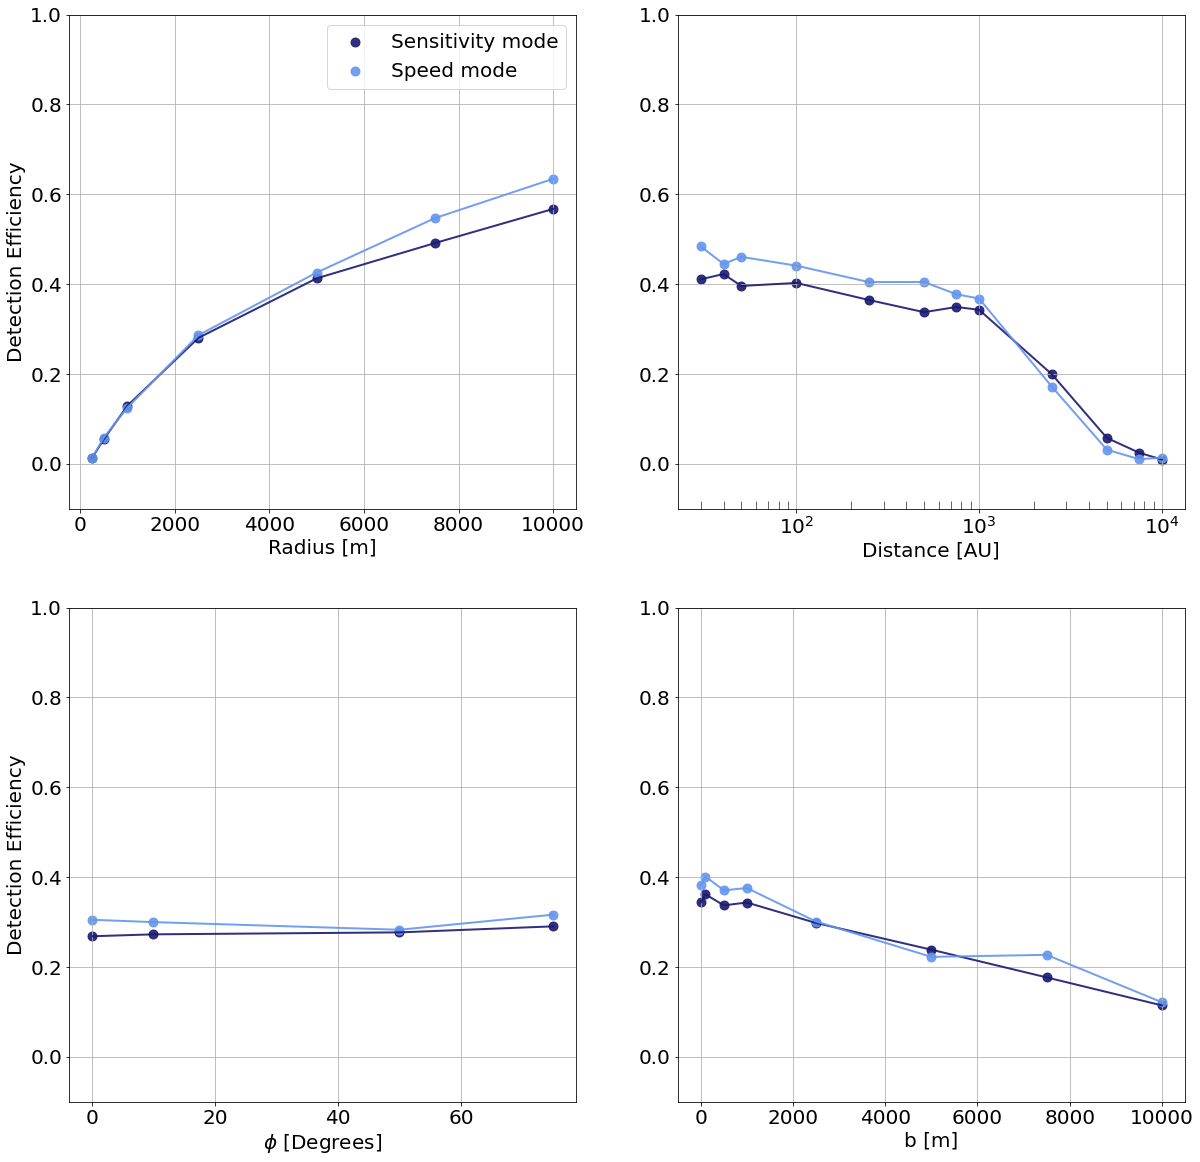

In [10]:
fig, ax = plt.subplots(figsize=(20,20), nrows=2, ncols=2)
fs = 20
color = 'midnightblue'
color_speed = 'cornflowerblue'
i_ = [0, 0, 1, 1]
j_ = [0, 1, 0, 1]
alpha = 0.9
for i, j, parameter_list, param_name, param_unit, index in zip(i_, j_, parameter_lists, parameter_names,
                                                     parameter_units, parameter_indices):
    #print(parameter_list, param_name, param_unit)
    ps, effs, effs_speed = compute_efficiency(parameter_list, recovered_all,
                                           missed_all, recovered_all_speed,
                       missed_all_speed, param_name, param_unit, index)

    
    ax[i][j].plot(ps, effs, lw=fs/10, c=color, alpha=alpha)
    ax[i][j].plot(ps, effs_speed, lw=fs/10, c=color_speed, alpha=alpha)
    ax[i][j].scatter(ps, effs, s=4*fs, c=color, alpha=alpha, label='Sensitivity mode')
    ax[i][j].scatter(ps, effs_speed, s=4*fs, c=color_speed, alpha=alpha, label='Speed mode')
    ax[i][j].set_xlabel('%s [%s]' % (param_name, param_unit), fontsize=fs)
    ax[i][j].set_ylim(-0.1, 1)

    if i == 0 and j == 1:
        ax[i][j].set_xscale('log')
        ax[i][j].tick_params(which='minor', direction='in', length=8, labelsize=fs)

        
    ax[i][j].grid()
    ax[i][j].tick_params(labelsize=fs)
    
    if j == 0:
        ax[i][j].set_ylabel('Detection Efficiency', fontsize=fs)
    
    if i == 0 and j == 0:
        ax[j][j].legend(fontsize=fs)

plt.savefig('Detection_efficiency.png', bbox_inches='tight')

In [11]:
def total_snrs(recovered, missed):
    all_snrs = []
    for rec_rad, rec_snr in zip(recovered[:,2], recovered[:,6]):
        all_snrs.append([rec_rad, rec_snr])
    for miss_rad, miss_snr in zip(missed[:,2], missed[:,6]):
        all_snrs.append([rec_rad, rec_snr])
    return np.array(all_snrs)

all_snrs = total_snrs(recovered_all, missed_all)
all_snrs_speed = total_snrs(recovered_all_speed, missed_all_speed)

all_snrs.shape, all_snrs_speed.shape

((44176, 2), (18213, 2))

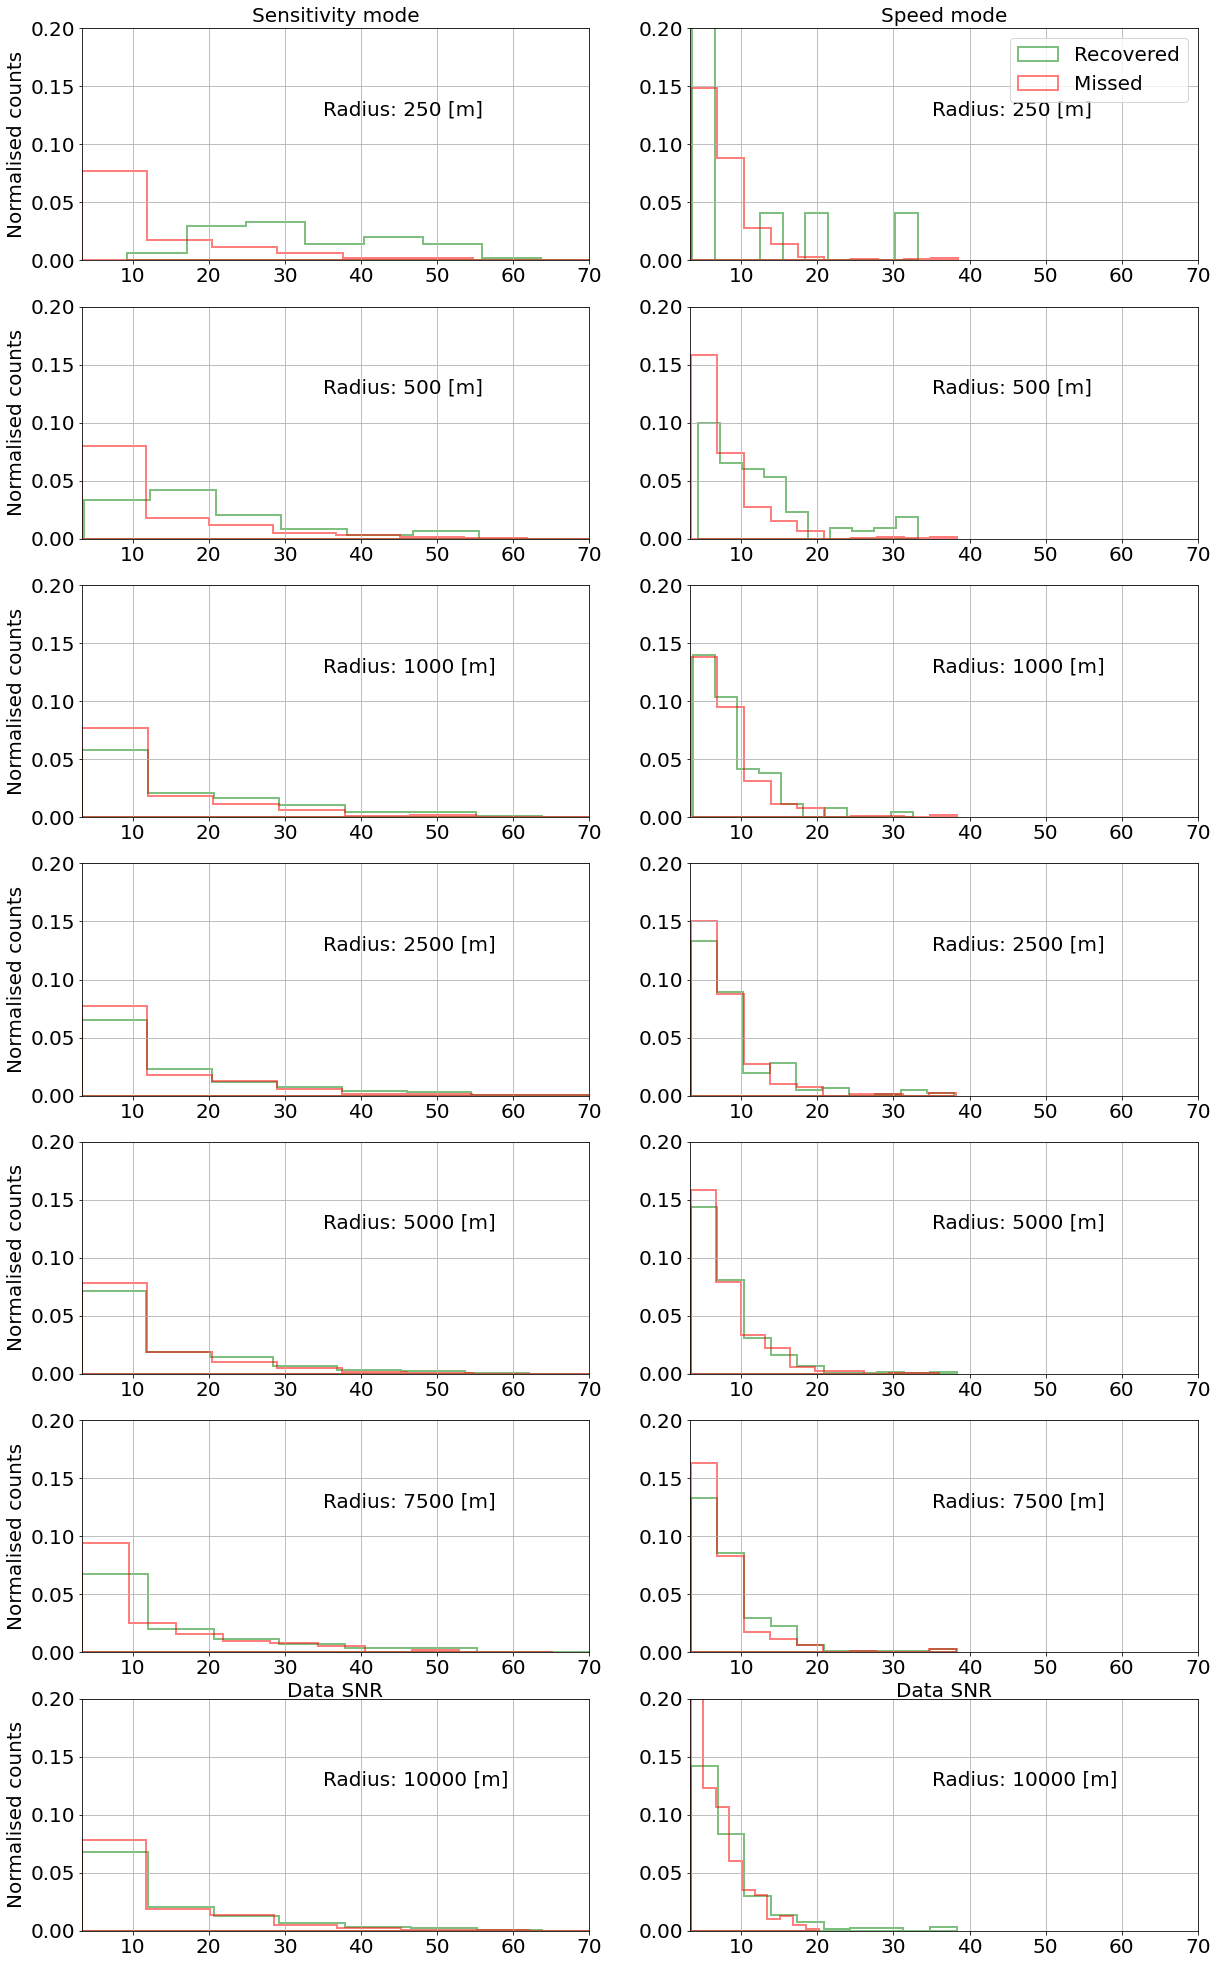

In [12]:
## SNR
alpha = 0.5
bins = 10
fs = 20
lw = 2

color_rec = 'green'
color_miss = 'red'

xmin, xmax = 3.3, 70
ymin, ymax = 0, 0.2

fig, ax = plt.subplots(figsize=(20,35), nrows=7, ncols=2)

i_ = [0, 1, 2, 3, 4, 5, 6]

for i, fixed_radius in zip(i_, radii):

    ax[i][0].hist(recovered_all[:,6][recovered_all[:,2] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
               edgecolor=color_rec, lw=lw, alpha=alpha, label='Recovered')[2]
    ax[i][0].hist(missed_all[:,6][missed_all[:,2] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
               edgecolor=color_miss, lw=lw, alpha=alpha, label='Missed')[2]
    #ax[0].hist(all_snrs[:,1][all_snrs[:,0] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
    #          edgecolor='k', lw=lw, alpha=alpha, label='Total')[2]
    ax[i][0].tick_params(labelsize=fs)
    #ax[i][0].set_xlabel('Data SNR', fontsize=fs)
    ax[i][0].set_ylabel('Normalised counts', fontsize=fs)
    #ax[i][0].set_title('Sensitivity mode', fontsize=fs)
    ax[i][0].set_xlim(xmin, xmax)
    ax[i][0].set_ylim(ymin, ymax)
    ax[i][0].grid()
    ax[i][0].text(35, 0.125, 'Radius: %d [m]' % fixed_radius, fontsize=fs)
    
    ax[i][1].hist(recovered_all_speed[:,6][recovered_all_speed[:,2] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
               edgecolor=color_rec, lw=lw, alpha=alpha, label='Recovered')[2]
    ax[i][1].hist(missed_all_speed[:,6][missed_all_speed[:,2] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
               edgecolor=color_miss, lw=lw, alpha=alpha, label='Missed')[2]
    #ax[1].hist(all_snrs_speed[:,1][all_snrs_speed[:,0] == fixed_radius], bins=bins, fill=False, density=True, histtype='stepfilled',
    #          edgecolor='k', lw=lw, alpha=alpha, label='Total')[2]
    ax[i][1].tick_params(labelsize=fs)
    
    #ax[i][1].set_xlabel('Data SNR', fontsize=fs)
    #ax[i][1].set_title('Speed mode', fontsize=fs)
    ax[i][1].set_xlim(xmin, xmax)
    ax[i][1].set_ylim(ymin, ymax)
    ax[i][1].grid()
    ax[i][1].text(35, 0.125, 'Radius: %d [m]' % fixed_radius, fontsize=fs)
   
    if i == 0:
        ax[i][0].set_title('Sensitivity mode', fontsize=fs)
        ax[i][1].set_title('Speed mode', fontsize=fs)
        ax[i][1].legend(fontsize=fs)
        
    if i == 5:
        ax[i][0].set_xlabel('Data SNR', fontsize=fs)
        ax[i][1].set_xlabel('Data SNR', fontsize=fs)
      
      
        

plt.savefig('SNR_hists.png', bbox_inches='tight')

In [13]:
def compute_efficiency_fixed_radius(parameter_list, recovered, missed, recovered_speed, missed_speed,
                                 param_name, param_units, param_index, fixed_radius):
    efficiencies = []
    efficiencies_speed = []
    efficiencies_uncertainties = []
    efficiencies_uncertainties_speed = []
    parameter_list_ = []        
    for param in parameter_list:
        # compute efficiency
        rec = len(np.where((recovered[:,param_index] == param) & (recovered[:,2] == fixed_radius))[0]) 
        miss = len(np.where((missed[:,param_index] == param) & (missed[:,2] == fixed_radius))[0]) 
        rec_speed = len(np.where((recovered_speed[:,param_index] == param) & (recovered_speed[:,2] == fixed_radius))[0]) 
        miss_speed = len(np.where((missed_speed[:,param_index] == param) & (missed_speed[:,2] == fixed_radius))[0]) 
        try:
            efficiency = rec / (rec + miss)
            efficiencies.append(efficiency)
            efficiency_speed = rec_speed / (rec_speed + miss_speed)
            efficiencies_speed.append(efficiency_speed)
            parameter_list_.append(param)
            
            
            efficiency_var = compute_variance(rec, miss, rec, miss)
            efficiencies_uncertainties.append(np.sqrt(efficiency_var))
            efficiency_var_speed = compute_variance(rec_speed, miss_speed, rec_speed, miss_speed)
            efficiencies_uncertainties_speed.append(np.sqrt(efficiency_var_speed))
            
        # skip if no samples available
        except ZeroDivisionError:
            continue
    

    return parameter_list, efficiencies, efficiencies_speed, efficiencies_uncertainties, efficiencies_uncertainties_speed

Distance
[0.6690909090909091, 0.7177914110429447, 0.6622390891840607, 0.7608695652173914, 0.7598425196850394, 0.6939655172413793, 0.7435897435897436, 0.7362204724409449, 0.6958333333333333, 0.24206349206349206, 0.09433962264150944, 0.038910505836575876]
[0.8045977011494253, 0.732620320855615, 0.7298578199052133, 0.8353909465020576, 0.8616600790513834, 0.8379446640316206, 0.8307086614173228, 0.8059701492537313, 0.6742081447963801, 0.12, 0.020202020202020204, 0.018691588785046728]
$\phi$
[0.5694259012016022, 0.5276653171390013, 0.5760801502817783, 0.5937304075235109]
[0.6495726495726496, 0.615595075239398, 0.6209553158705701, 0.65625]
b
[0.5521978021978022, 0.5965166908563135, 0.5588972431077694, 0.5515695067264574, 0.6147186147186147, 0.5525, 0.5464333781965006, 0.5753920386007237]
[0.6096938775510204, 0.5914634146341463, 0.5481727574750831, 0.6540697674418605, 0.6888888888888889, 0.5867507886435331, 0.7557471264367817, 0.6380368098159509]


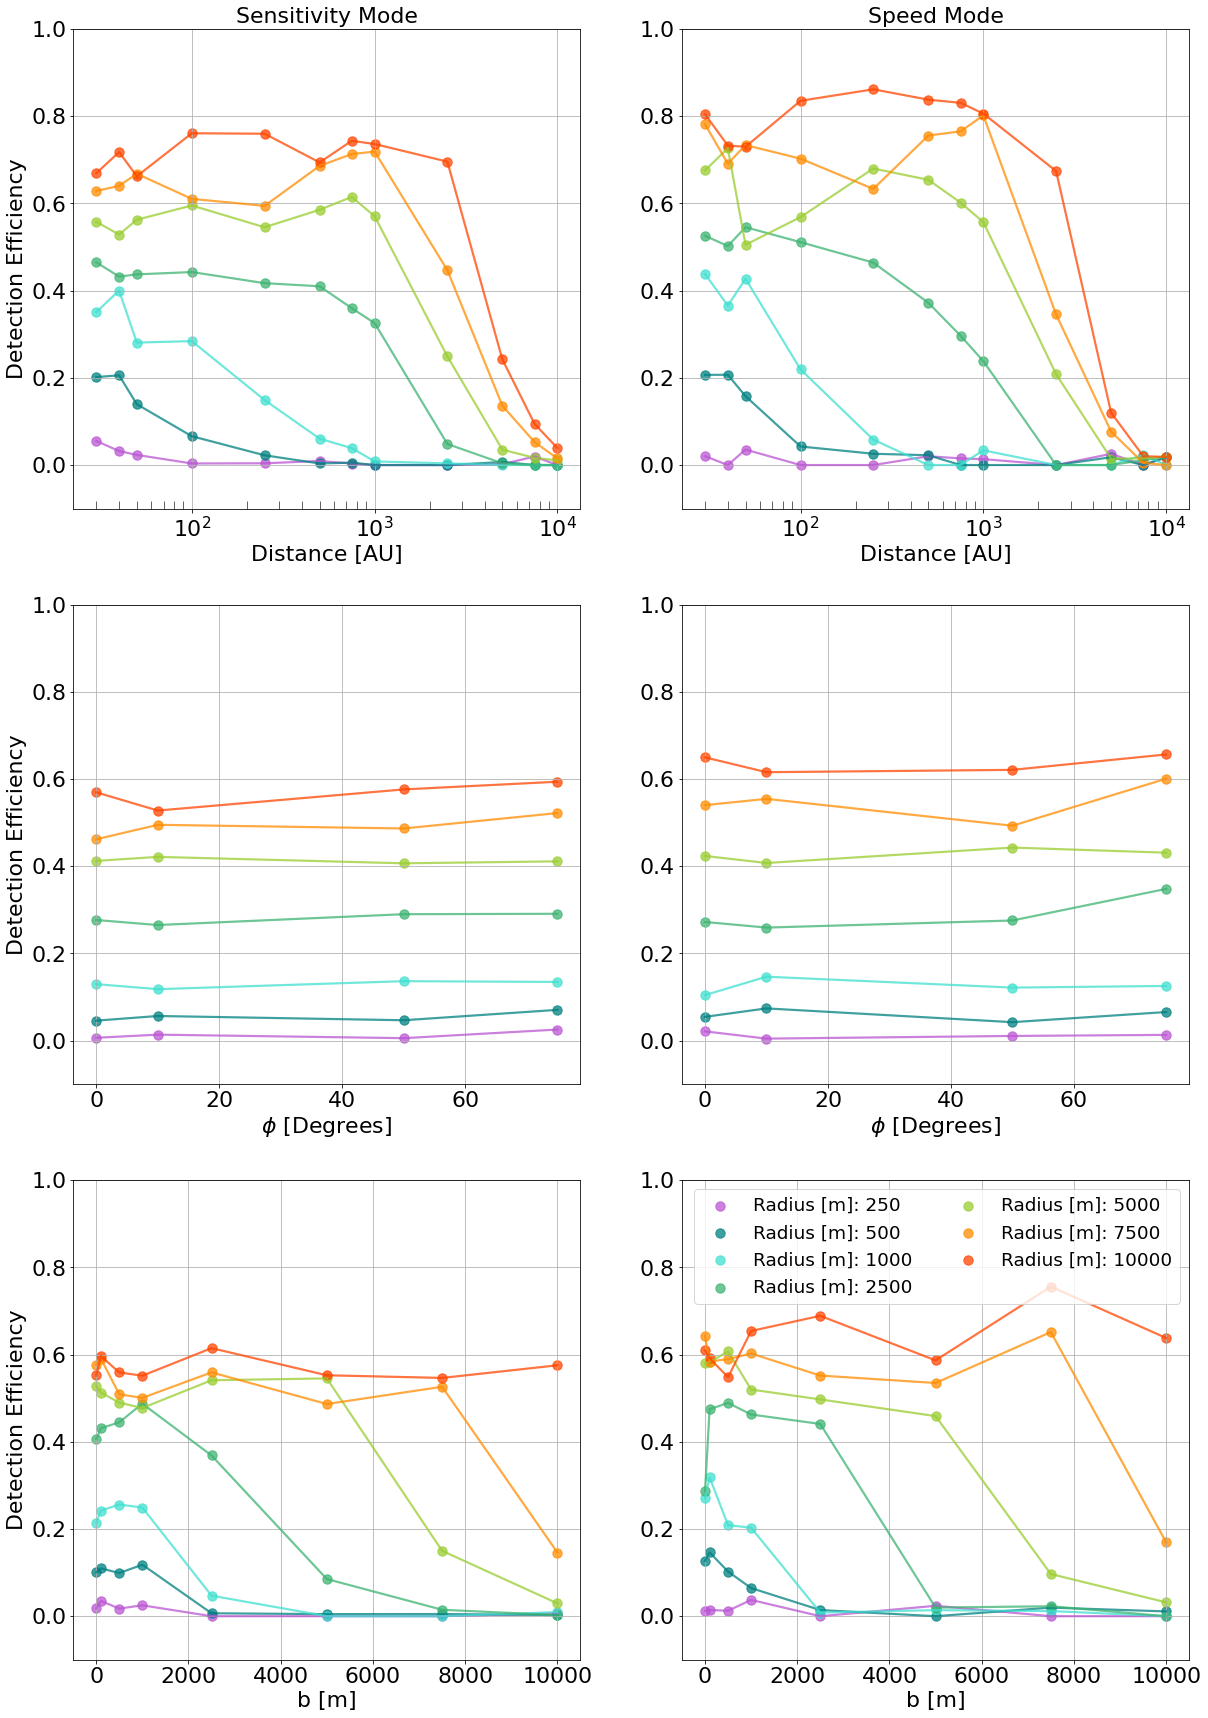

In [14]:
radii = [250, 500, 1000, 2500, 5000, 7500, 10000] # m
dists = [30, 40, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000] # Au
phis = [0, 10, 50, 75] # degrees
bs = [0, 100, 500, 1000, 2500, 5000, 7500, 10000] # m

parameter_lists = [dists, phis, bs]
parameter_names = ['Distance', '$\phi$', 'b']
parameter_units = ['AU', 'Degrees', 'm']
parameter_indices = [3, 4, 5]

colors = ['mediumorchid', 'teal', 'turquoise', 'mediumseagreen', 'yellowgreen', 'darkorange', 'orangered']


fig, ax = plt.subplots(figsize=(20,30), nrows=3, ncols=2)
fs = 22
alpha = 0.75

i_ = [0, 1, 2]
j_ = [0, 0, 0]

for f,frad in enumerate(radii):
    #print('Radius:', frad)
    for i, j, parameter_list, param_name, param_unit, index in zip(i_, j_, parameter_lists, parameter_names,
                                                         parameter_units, parameter_indices):
  
        ps, effs, effs_speed, effs_un, effs_un_speed = compute_efficiency_fixed_radius(parameter_list,
                                                                 recovered_all, missed_all,
                                        recovered_all_speed, missed_all_speed,
                                        param_name, param_unit, index, fixed_radius=frad)
    
        if frad == 10000:
            print(param_name)
            print(effs)
            print(effs_speed)
        
        if i == 0:
            ax[i][j].set_xscale('log')
            ax[i][j].tick_params(which='minor', direction='in', length=8, labelsize=fs)    
            ax[i][j+1].set_xscale('log')
            ax[i][j+1].tick_params(which='minor', direction='in', length=8, labelsize=fs) 
        
        ax[i][j].plot(ps, effs, c=colors[f], lw=fs/10, alpha=alpha)
        ax[i][j].scatter(ps, effs, c=colors[f], s=4*fs, alpha=alpha, label='Radius [m]: %d' % radii[f])
        #ax[i][j].errorbar(ps, effs, effs_un, c=colors[f], alpha=alpha)
        ax[i][j].set_xlabel('%s [%s]' % (param_name, param_unit), fontsize=fs)
        ax[i][j].set_ylim(-0.1, 1)
        ax[i][j].grid(b=True)
        ax[i][j].tick_params(labelsize=fs)
       
        ax[i][j+1].plot(ps, effs_speed, c=colors[f], lw=fs/10, alpha=alpha)
        ax[i][j+1].scatter(ps, effs_speed, c=colors[f], s=4*fs, alpha=alpha, label='Radius [m]: %d' % radii[f])
        #ax[i][j+1].errorbar(ps, effs_speed, effs_un_speed, c=colors[f], alpha=alpha)
        ax[i][j+1].set_xlabel('%s [%s]' % (param_name, param_unit), fontsize=fs)
        ax[i][j+1].set_ylim(-0.1, 1)
        ax[i][j+1].grid(b=True)
        ax[i][j+1].tick_params(labelsize=fs)

        ax[i][j].set_ylabel('Detection Efficiency', fontsize=fs)

        if i == 2 and j == 0:
            ax[i][j+1].legend(ncol=2, fontsize=fs-3.5)
            
        if i == 0:
            ax[i][j].set_title('Sensitivity Mode', fontsize=fs)
            ax[i][j+1].set_title('Speed Mode', fontsize=fs)
 
plt.savefig('Detection_efficiency_radius.png', bbox_inches='tight')

In [15]:
### effective sky coverage an upper limits
def omega(w, D, phi, lam, delta, theta, E):
    # w: fraction of light curves implanted with occulations by objects of Diameter D
    # r: object radius in m
    # theta: stellar angular diameter in mas
    # lam: observation wavelength in m
    # delta: object distance in AU
    # phi: orbital angle in degrees
    # E: duration of light curve seconds
            
    # stellar angular size in degrees^2
    theta_degrees = (theta / 1000) * (1 / 3600)
    theta_area = np.pi * ((0.5 * theta_degrees)**2)
    
    # Fresnel scale
    delta_ = delta * 1.496e11 # convert AU -> metres
    F = (0.5 * lam * delta_) ** (1/2)
    
    # event cross section
    H = (((2 * np.sqrt(3) * F) ** (3/2)) + (D ** (3/2))) ** (2/3) + (theta_area * delta_)
    
    # relative transverse velocity
    phi_rad = phi * (np.pi / 180)
    vE = 29800 # Earth's orbital speed in m/s
    v_rel = vE * (np.cos(phi_rad) - ((1/delta) * (1 - (np.sin(phi_rad)**2)))**(1/2))
    
    return (1/w) * np.sum((H / delta_) * (v_rel / delta_) * E)
    
    

In [16]:
#omega(w=0.1, D=1000, phi=30, lam=6e-7, delta=40, theta=0.02, E=100000)

In [17]:
# unpack parameters of recovered events
radii_, dists_, phis_, durations_ = recovered_all[:,2], recovered_all[:,3], recovered_all[:,4], recovered_all[:,6]
radii_speed, dists_speed, phis_speed, durations_speed = recovered_all_speed[:,2], recovered_all_speed[:,3], recovered_all_speed[:,4], recovered_all_speed[:,6]
radii = np.concatenate((radii_, radii_speed))
dists = np.concatenate((dists_, dists_speed))
phis = np.concatenate((phis_, phis_speed))
durations = np.concatenate((durations_, durations_speed))

In [18]:
radii = [250, 500, 1000, 2500, 5000, 7500, 10000] # m
omegas = []

for rad in radii:
    
    # fix radius
    rec_r_ = recovered_all[recovered_all[:,2] == rad]
    missed_r_ = missed_all[missed_all[:,2] == rad]
    #rec_r_speed = recovered_all_speed[recovered_all_speed[:,2] == rad]
    #missed_r_speed = missed_all_speed[missed_all_speed[:,2] == rad]
    
    # fix distance
    fix_dist = 40
    rec_r_ = rec_r_[rec_r_[:,3] == fix_dist]
    missed_r_ = missed_r_[missed_r_[:,3] == fix_dist]
    #rec_r_speed = rec_r_speed[rec_r_speed[:,3] == fix_dist]
    #missed_r_speed = missed_r_speed[missed_r_speed[:,3] == fix_dist]
    
    # concatenate data sets
    #rec_r = np.concatenate((rec_r_, rec_r_speed))
    #missed_r = np.concatenate((missed_r_, missed_r_speed))
    rec_r = rec_r_
    missed_r = missed_r_

    # fraction of simulations assocaited with this radius
    #w = (rec_r.shape[0] + missed_r.shape[0]) / (recovered_all.shape[0] + recovered_all_speed.shape[0]
    #       + missed_all.shape[0] + missed_all_speed.shape[0])
    w = (rec_r.shape[0] + missed_r.shape[0]) / (recovered_all.shape[0] + missed_all.shape[0])

    dists, phis, durations = rec_r[:,3], rec_r[:,4], rec_r[:,6]
    
    # compute sky coverage as a function of diameter
    omegas.append(omega(w=w, D=2*rad, phi=phis, lam=6e-7, delta=dists, theta=0.02, E=durations))
   
omegas = np.array(omegas)

In [19]:
diameters_z13 = [0.5, 0.6, 0.7, 1, 1.5, 2, 3, 5, 8, 15, 30]
omegas_z13 = np.array([9e-10, 8.5e-9, 4e-8, 3.5e-7, 8e-7, 2e-6, 4e-6, 9e-6, 1.8e-5, 4e-5, 5e-5])
diameters_b10 = [20, 8, 3, 2, 1.5, 1, 0.7, 0.5]
log_N_b10 = [4.8, 5.4, 6.2, 6.4, 6.7, 7.2, 8, 9.8]

Text(0, 0.5, '$\\Omega$ [deg^2]')

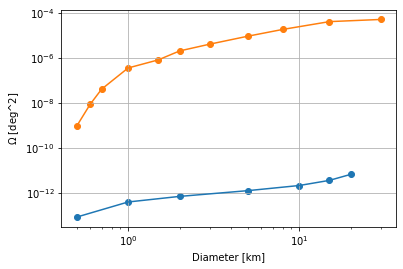

In [44]:
diameters = 2 * np.array(radii) / 1000
plt.plot(diameters, omegas)
plt.scatter(diameters, omegas)
plt.scatter(diameters_z13, omegas_z13)
plt.plot(diameters_z13, omegas_z13)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Diameter [km]')
plt.ylabel('$\Omega$ [deg^2]')

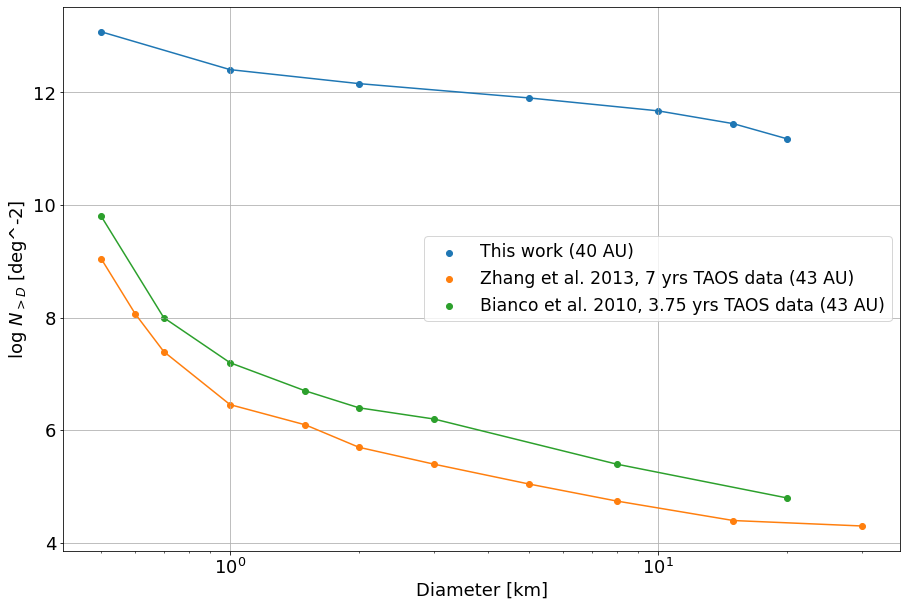

In [52]:
fs = 18
plt.figure(figsize=(15,10))
plt.plot(diameters, np.log10(1 / omegas))
plt.scatter(diameters, np.log10(1 / omegas), label='This work (40 AU)')
plt.plot(diameters_z13,np.log10(1 / omegas_z13))
plt.scatter(diameters_z13, np.log10(1 / omegas_z13), label='Zhang et al. 2013, 7 yrs TAOS data (43 AU)')
plt.plot(diameters_b10, log_N_b10)
plt.scatter(diameters_b10, log_N_b10, label='Bianco et al. 2010, 3.75 yrs TAOS data (43 AU)')
plt.tick_params(labelsize=fs)
plt.grid()
plt.legend(fontsize='xx-large')
plt.xscale('log')
plt.xlabel('Diameter [km]', fontsize=fs)
plt.ylabel('log $N_{>D}$ [deg^-2]', fontsize=fs)
plt.savefig('constraints.png', bbox_inches='tight')

In [21]:
x1 = 29824
x2 = 100178
window = 1000
grid = np.arange(x1, x2, window) + (window/2)
grid = grid.astype(int)
grid

array([ 30324,  31324,  32324,  33324,  34324,  35324,  36324,  37324,
        38324,  39324,  40324,  41324,  42324,  43324,  44324,  45324,
        46324,  47324,  48324,  49324,  50324,  51324,  52324,  53324,
        54324,  55324,  56324,  57324,  58324,  59324,  60324,  61324,
        62324,  63324,  64324,  65324,  66324,  67324,  68324,  69324,
        70324,  71324,  72324,  73324,  74324,  75324,  76324,  77324,
        78324,  79324,  80324,  81324,  82324,  83324,  84324,  85324,
        86324,  87324,  88324,  89324,  90324,  91324,  92324,  93324,
        94324,  95324,  96324,  97324,  98324,  99324, 100324])

In [34]:
def compute_variance(a, b, var_a, var_b):
    return (((b / (a + b) ** 2) ** 2) *  var_a) + (((a / (a + b) ** 2) ** 2) *  var_b)

compute_variance(447764, 9, 447764, 9)

4.488673067665341e-11

In [35]:
compute_variance(231, 75, 231, 75)

0.0006046568313343536

In [1]:
### Trojan work

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### effective sky coverage an upper limits
def omega(w, D, phi, lam, delta, theta, E):
    # w: fraction of light curves implanted with occulations by objects of Diameter D
    # r: object radius in m
    # theta: stellar angular diameter in mas
    # lam: observation wavelength in m
    # delta: object distance in AU
    # phi: orbital angle in degrees
    # E: duration of light curve seconds
            
    # stellar angular size in degrees^2
    theta_degrees = (theta / 1000) * (1 / 3600)
    theta_area = np.pi * ((0.5 * theta_degrees)**2)
    
    # Fresnel scale
    delta_ = delta * 1.496e11 # convert AU -> metres
    F = (0.5 * lam * delta_) ** (1/2)
    
    # event cross section
    H = (((2 * np.sqrt(3) * F) ** (3/2)) + (D ** (3/2))) ** (2/3) + (theta_area * delta_)
    
    # relative transverse velocity
    phi_rad = phi * (np.pi / 180)
    #vE = 29800 # Earth's orbital speed in m/s
    vE = 13e3
    v_rel = vE * (np.cos(phi_rad) - ((1/delta) * (1 - (np.sin(phi_rad)**2)))**(1/2))
    
    #return (1/w) * np.sum((H / delta_) * (v_rel / delta_) * E)
    return (H / delta_) * (v_rel / delta_) * E
    
def dN_dD(D, k, beta=1.85):
    return - beta * k * (D ** (- beta - 1))

In [35]:
n_star = 1000
D_ = np.linspace(50, 1e4, 100)
w = 1
phi = 0
lam = 6e-7
delta = 4
theta = 0.2
#E = 3 * 365 * 24 * 60 * 60
E = 7 * 8 * 60 * 60

n_expected = []
for D in D_:
    omegas = []
    n_expected.append(-dN_dD(D/1000, k=1e5, beta=1.85) * (n_star * omega(w, D, phi, lam, delta, theta, E)))

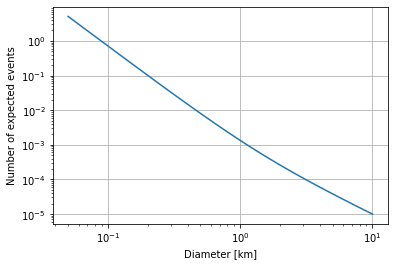

In [36]:
plt.plot(D_ / 1000, n_expected)
plt.xlabel('Diameter [km]')
plt.ylabel('Number of expected events')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig('Expected_events.png', bbox_inches='tight')

In [121]:
def N(D1, D2, q):
    #return ((D2 ** (-(q - 1))) - (D1 ** (-(q - 1)))) / (q - 1)
    return ((D2 + D1) ** (1 - q)) - (D1 ** (1 - q)) / (1 - q)
5e4 * N(50, 60, 4) * (20 * 360)

1230.4733283245678